<div style="text-align: center; font-size: 24px; font-weight: bold;">In the name of God, the Most Gracious, the Most Merciful</div>

Full Name: MohammadDavood VahhabRajaee

Student ID: 4041419041

# Systematic Ablation Study on Fully Connected Networks for Fashion-MNIST

This Jupyter Notebook implements a comprehensive systematic ablation study to investigate the effects of various architectural components and regularization techniques on the performance of fully connected neural networks using the Fashion-MNIST dataset.

## 1.Imports

Import necessary Python libraries for the experiment.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import time
from datetime import datetime
from typing import List, Optional

## 2.Reproducibility

Ensure consistent results across runs by setting random seeds.

In [2]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 3.Configurable Fully Connected Network

The FCNet class implements a highly configurable fully connected neural network that supports various activation functions, regularization techniques, and architectural variations.

In [3]:
class FCNet(nn.Module):
    def __init__(
        self,
        input_size: int = 28 * 28,
        hidden_sizes: List[int] = [256, 128],
        num_classes: int = 10,
        activation: str = "relu",
        use_batchnorm: bool = False,
        dropout_rate: float = 0.0,
        maxout_groups: int = 2,
    ):
        super().__init__()
        self.activation_name = activation
        self.use_batchnorm = use_batchnorm
        self.dropout_rate = dropout_rate
        self.maxout_groups = maxout_groups
        self.num_classes = num_classes

        layers = []
        prev_size = input_size

        # Build hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_size))

            # Add activation (as module, except linear & maxout)
            if activation == "relu":
                layers.append(nn.ReLU())
            elif activation == "leaky_relu":
                layers.append(nn.LeakyReLU(0.01))
            elif activation == "tanh":
                layers.append(nn.Tanh())
            elif activation == "sigmoid":
                layers.append(nn.Sigmoid())
            # 'linear' and 'maxout' → no activation here

            # Add dropout after activation (standard)
            if dropout_rate > 0 and activation != "linear":
                layers.append(nn.Dropout(dropout_rate))

            prev_size = hidden_size

        # Output layer
        if activation == "maxout":
            # Output size: num_classes * groups
            self.output_layer = nn.Linear(prev_size, num_classes * maxout_groups)
        else:
            layers.append(nn.Linear(prev_size, num_classes))
            self.output_layer = None

        self.feature_layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten

        x = self.feature_layers(x)

        if self.activation_name == "maxout":
            # Apply maxout: (B, C*G) → (B, G, C) → max over G → (B, C)
            x = self.output_layer(x)  # (B, num_classes * groups)
            x = x.view(x.size(0), self.maxout_groups, self.num_classes)
            x = torch.max(x, dim=1)[0]  # (B, num_classes)
        else:
            # output layer is last in Sequential
            pass  # already applied

        return x

## 4.Data Loaders

The data loading process is designed to efficiently handle the Fashion-MNIST dataset with proper preprocessing, validation splitting, and optional data augmentation to support robust model training and evaluation.
Step-by-Step Process
1. Base Transform Pipeline

- Image to Tensor Conversion: Converts PIL images to PyTorch tensors

- Dataset-Specific Normalization: Uses precomputed Fashion-MNIST statistics

    - Mean: 0.2860

    - Standard Deviation: 0.3530

- Purpose: Standardizes input data to improve training stability and convergence

2. Training Data Augmentation (Optional)

When augmentation is enabled, the training data undergoes:

- Random Affine Transformations:

    - Rotation: Up to 10 degrees

    - Translation: Up to 10% of image dimensions

    - Scaling: Between 90% and 110% of original size

- Purpose: Increases dataset diversity and improves model generalization by simulating real-world variations

3. Dataset Loading

- Full Training Set: Loads entire Fashion-MNIST training dataset (60,000 images)

- Test Set: Loads separate test dataset (10,000 images)

- Automatic Download: Downloads dataset if not already present in './data' directory

4. Train-Validation Split

- Split Ratio: 90% training, 10% validation (standard practice)

- Stratified Splitting: Uses PyTorch's random_split with fixed seed for reproducibility

- Validation Set Integrity: Ensures validation data uses base transforms only (no augmentation) to provide unbiased evaluation

5. DataLoader Configuration

Each DataLoader is configured with:

Training DataLoader:

- Shuffling: Enabled to prevent order bias during training

- Worker Initialization: Sets seeds for each worker to maintain reproducibility

- Purpose: Provides randomized batches for stochastic gradient descent

Validation DataLoader:

- No Shuffling: Maintains consistent order for reliable evaluation

- Purpose: Provides consistent batches for model validation

Test DataLoader:

- No Shuffling: Maintains dataset order for final evaluation

- Purpose: Provides final unbiased performance assessment

6. Reproducibility Measures

- Fixed Random Seeds: Ensures consistent dataset splits across runs

- Generator Seeding: Controls random number generation for shuffling

- Worker Initialization: Each data loading worker gets unique, deterministic seed

In [4]:
def get_data_loaders(batch_size=64, use_augmentation=False, val_split=0.1, seed=42):
    # Base transform (shared)
    base_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.2860,), (0.3530,))
    ])

    # Augmentation only for training
    if use_augmentation:
        train_transform = transforms.Compose([
            transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            base_transform
        ])
    else:
        train_transform = base_transform

    # Load full training dataset
    full_train_set = torchvision.datasets.FashionMNIST(
        root='./data', train=True, download=True, transform=train_transform
    )
    test_set = torchvision.datasets.FashionMNIST(
        root='./data', train=False, download=True, transform=base_transform
    )

    # Split train → train + val
    n_train = len(full_train_set)
    n_val = int(val_split * n_train)
    n_train = n_train - n_val
    train_subset, val_subset = torch.utils.data.random_split(
        full_train_set, [n_train, n_val],
        generator=torch.Generator().manual_seed(seed)
    )
    # Ensure val uses base transform (no augmentation!)
    val_subset.dataset.transform = base_transform

    # DataLoaders
    g = torch.Generator()
    g.manual_seed(seed)

    train_loader = DataLoader(
        train_subset, batch_size=batch_size, shuffle=True,
        num_workers=2, pin_memory=True, worker_init_fn=lambda w: set_seed(seed + w)
    )
    val_loader = DataLoader(
        val_subset, batch_size=batch_size, shuffle=False,
        num_workers=2, pin_memory=True
    )
    test_loader = DataLoader(
        test_set, batch_size=batch_size, shuffle=False,
        num_workers=2, pin_memory=True
    )

    return train_loader, val_loader, test_loader

## 5.Training & Evaluation Loop

This component implements the core training and validation process, handling model optimization, metric tracking, and learning rate scheduling in a reproducible and robust manner.
Step-by-Step Process
1. Initial Setup Phase

- Device Placement: Moves model to appropriate device (GPU if available, otherwise CPU)

- Loss Function: Uses CrossEntropyLoss (standard for multi-class classification)

- Optimizer: Adam optimizer with configurable learning rate and weight decay (L2 regularization)

- Learning Rate Scheduler: ReduceLROnPlateau - automatically reduces learning rate when validation loss stops improving

2. Training Phase (Per Epoch)

**Model Preparation**

- Sets model to training mode (enables dropout, batch norm updates)

- Initializes metrics tracking: loss, correct predictions, total samples

**Batch Processing Loop**

For each training batch:

- Data Transfer: Moves inputs and targets to computation device with non-blocking transfers

- Gradient Reset: Clears previous gradients using set_to_none=True for efficiency

- Forward Pass: Computes model predictions

- Loss Calculation: Computes cross-entropy loss between predictions and true labels

- NaN Check: Monitors for numerical instability and raises error if detected

- Backward Pass: Computes gradients through backpropagation

- Gradient Clipping: Optional gradient norm clipping to prevent explosion

- Parameter Update: Applies optimizer step to update model weights

- Metric Accumulation: Tracks running loss and accuracy

**Epoch Statistics**

- Average Loss: Total loss normalized by dataset size

- Accuracy: Percentage of correct predictions

- Time Tracking: Measures epoch duration for performance monitoring

3. Validation Phase (Per Epoch)

**Model Preparation**

- Sets model to evaluation mode (disables dropout, fixes batch norm statistics)

- Disables gradient computation for efficiency

**Batch Processing Loop**

For each validation batch:

- Forward Pass Only: Computes predictions without gradient calculation

- Loss and Accuracy: Calculates validation metrics same as training

- No Parameter Updates: Validation is purely for evaluation, no learning occurs

4. Metrics Management

**History Tracking**

- Loss Curves: Stores training and validation losses per epoch

- Accuracy Curves: Stores training and validation accuracies per epoch

- Final Metrics: Records end-of-training performance

**Best Model Tracking**

- Best Validation Accuracy: Maintains highest validation accuracy encountered

- Best Epoch: Records which epoch achieved the best performance

- Purpose: Enables model selection and early stopping considerations

5. Learning Rate Adaptation

**Dynamic Scheduling**

- Monitor Metric: Uses validation loss as scheduling criterion

- Patience Mechanism: Waits 3 epochs without improvement before reducing LR

- Reduction Factor: Cuts learning rate by 50% when triggered

- Purpose: Automatically fine-tunes learning rate for better convergence

6. Progress Monitoring

**Verbose Output**

When enabled, displays per-epoch information:

- Training Metrics: Loss and accuracy

- Validation Metrics: Loss and accuracy

- Learning Rate: Current learning rate value

- Timing Information: Epoch duration for performance analysis

In [5]:
def train_and_evaluate(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    epochs: int = 20,
    lr: float = 1e-3,
    weight_decay: float = 1e-4,
    verbose: bool = False,
    grad_clip: Optional[float] = None,
) -> dict:
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    best_val_acc = 0.0
    best_epoch = 0

    for epoch in range(epochs):
        start_time = time.time()

        # Training
        model.train()
        total_loss, correct, total = 0.0, 0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            if torch.isnan(loss):
                raise ValueError(f"NaN loss at epoch {epoch+1}")

            loss.backward()

            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            optimizer.step()

            total_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_loss = total_loss / len(train_loader.dataset)
        train_acc = 100. * correct / total

        # Validation
        model.eval()
        total_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                total_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        val_loss = total_loss / len(val_loader.dataset)
        val_acc = 100. * correct / total

        # Update histories
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Scheduler & tracking
        scheduler.step(val_loss)
        epoch_time = time.time() - start_time

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1

        if verbose and (epoch + 1) % 1 == 0:  # or %5
            lr_current = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1:2d}/{epochs} | "
                  f"Train Loss: {train_loss:.4f}, Acc: {train_acc:5.2f}% | "
                  f"Val Loss: {val_loss:.4f}, Acc: {val_acc:5.2f}% | "
                  f"LR: {lr_current:.1e} | Time: {epoch_time:.1f}s")

    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'final_train_loss': train_losses[-1],
        'final_train_acc': train_accs[-1],
        'final_val_loss': val_losses[-1],
        'final_val_acc': val_accs[-1],
        'best_val_acc': best_val_acc,
        'best_epoch': best_epoch,
        'epochs': epochs
    }

## 6.Experiment Runner + CSV Logger

This component serves as the central orchestration system that manages individual experiment execution, handles errors gracefully, and maintains comprehensive logging for the entire ablation study.
Step-by-Step Process
1. Experiment Initialization

**Setup Phase**

- Run Identification: Each experiment gets a unique identifier based on configuration

- Configuration Display: Prints experiment details for transparency and monitoring

- Reproducibility Setup: Resets random seeds before each run to ensure consistent starting conditions

2. Data Preparation

- Loader Generation: Creates fresh train, validation, and test data loaders for each experiment

- Configuration Application: Applies specific batch size and augmentation settings from the experiment config

- Data Consistency: Ensures each model sees identical data splits and transformations

3. Model Instantiation & Validation

**Model Creation**

- Parameter Application: Builds FCNet with exact specifications from experiment configuration

- Device Placement: Moves model to appropriate computation device (GPU/CPU)

**Sanity Checking**

- Forward Pass Test: Performs a single forward pass with a small batch

- Output Shape Verification: Confirms model produces correct output dimensions (batch_size × num_classes)

- Error Detection: Catches and reports model architecture issues before full training

- Early Failure: Returns immediately if sanity check fails to save computation time

4. Training Execution

**Timed Execution**

- Start Time Capture: Records precise training start time

- Error Handling Wrapper: Encapsulates training in try-catch block for robustness

- Duration Calculation: Measures total training time for performance analysis

**Graceful Failure Handling**

- Exception Capture: Catches and logs any training errors (NaN losses, convergence issues, etc.)

- Continuation Assurance: Ensures one failed experiment doesn't halt the entire study

- Error Reporting: Provides detailed error messages for debugging

5. Results Compilation & Logging

**Comprehensive Result Collection**

- Success/Failure Status: Records whether experiment completed successfully

- Performance Metrics: Captures final training and validation losses/accuracies

- Training Duration: Logs total experiment time

- Configuration Summary: Includes all relevant experiment parameters

Standardized Data Structure

Each experiment produces a consistent record containing:

- Identification: Run ID and timestamp

- Status Information: Success/failure state and error messages

- Architecture Details: Activation functions, layer sizes, regularization settings

- Performance Metrics: Final losses and accuracies

- Resource Usage: Training time and epoch count

6. Persistent Storage

**SV Logging System**

- Append Mode: Adds new results to existing file without overwriting previous experiments

- Header Management: Creates file with headers if new, appends without headers if existing

- Robust File Handling: Gracefully handles file existence checks and access issues

**Additional Data Storage**

- Training Curves: Saves complete loss and accuracy histories as NumPy files

- File Naming: Uses run_id for unique curve file identification

- Success-Only Storage: Only saves detailed curves for successful experiments

7. Progress Reporting

**Real-time Feedback**

- Completion Status: Clear success/failure indicators

- Performance Summary: Key metrics (validation accuracy and duration) for quick assessment

- Progress Tracking: Shows experiment count and completion status

In [6]:
def run_experiment(config: dict, run_id: str, results_csv: str = "results.csv"):
    print(f"\n{'='*70}")
    print(f"Running: {run_id}")
    print(f"Config: {config}")
    print('='*70)

    # Ensure reproducibility per run
    set_seed(42)  # or: set_seed(abs(hash(run_id)) % (2**32 - 1))

    # Data: Now expects 3 loaders, uses val for training loop
    train_loader, val_loader, test_loader = get_data_loaders(  # ← updated signature!
        batch_size=config.get("batch_size", 64),
        use_augmentation=config["use_augmentation"],
        seed=42
    )

    # Model
    model = FCNet(
        input_size=28*28,
        hidden_sizes=config["hidden_sizes"],
        num_classes=10,
        activation=config["activation"],
        use_batchnorm=config["use_batchnorm"],
        dropout_rate=config["dropout_rate"],
        maxout_groups=config.get("maxout_groups", 2)
    )
    model.to(device)

    # Sanity check
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(train_loader))
        x = x[:1].to(device)
        try:
            out = model(x)
            assert out.shape == (1, 10), f"Wrong output shape: {out.shape}"
        except Exception as e:
            print(f"Model sanity check failed: {e}")
            return None, None

    # Train
    t0 = time.time()
    metrics = None
    error_msg = None
    try:
        metrics = train_and_evaluate(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,  # ← true validation set
            epochs=config.get("epochs", 20),
            lr=config.get("lr", 1e-3),
            weight_decay=config.get("weight_decay", 1e-4),
            verbose=False
        )
    except Exception as e:
        error_msg = str(e)
        print(f"Training failed: {error_msg}")

    duration = time.time() - t0

    # Always log — even failures
    row = {
        'run_id': run_id,
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'status': 'success' if metrics else 'failed',
        'error': error_msg if error_msg else '',
        'activation': config["activation"],
        'num_layers': len(config["hidden_sizes"]),
        'hidden_sizes': '-'.join(map(str, config["hidden_sizes"])),  # CSV-safe
        'use_batchnorm': config["use_batchnorm"],
        'dropout_rate': config["dropout_rate"],
        'use_augmentation': config["use_augmentation"],
        'final_train_loss': round(metrics['final_train_loss'], 4) if metrics else None,
        'final_train_acc': round(metrics['final_train_acc'], 2) if metrics else None,
        'final_val_loss': round(metrics['final_val_loss'], 4) if metrics else None,
        'final_val_acc': round(metrics['final_val_acc'], 2) if metrics else None,
        'duration_sec': round(duration, 1),
        'epochs': config.get("epochs", 20)
    }

    # Save to CSV (robust)
    df_row = pd.DataFrame([row])
    if os.path.exists(results_csv):
        df_row.to_csv(results_csv, mode='a', header=False, index=False)
    else:
        df_row.to_csv(results_csv, index=False)

    # Save curves only on success
    if metrics:
        curves_file = f"curves_{run_id}.npz"
        np.savez(curves_file,
                 train_losses=metrics['train_losses'],
                 train_accs=metrics['train_accs'],
                 val_losses=metrics['val_losses'],
                 val_accs=metrics['val_accs'])

    if metrics:
        print(f"Completed in {duration:.1f}s | Val Acc: {row['final_val_acc']:.2f}%")
    else:
        print(f"Failed after {duration:.1f}s")

    return row, metrics

## 7.Define Experiments

This section systematically defines the complete set of experiments for the ablation study, creating a structured framework to test individual components and their interactions in neural network architecture.

Experimental Design Philosophy

**Systematic Ablation Approach**

The experiments follow a controlled variable methodology where:

- Baseline models establish performance references

- Individual components are tested in isolation

- Combination effects are examined systematically

- Architectural variations explore structural impacts

**Experiment Categories**

1. Linearity Baselines (4 Experiments)

Purpose: Establish performance floor with minimal models

Configurations:

- Linear Baseline: Pure linear transformations only (no activations, no regularization)

- Linear + BatchNorm: Tests if normalization helps even without non-linearity

- Linear + Dropout: Examines if dropout provides benefits in linear models

- Linear + Full Regularization: Tests all regularization techniques combined

Scientific Value: Isolates the contribution of non-linearities by showing what linear models can achieve.

2. Nonlinearity Baselines (6 Experiments)

Purpose: Test different activation functions under identical conditions

Activation Functions Tested:

- ReLU: Standard rectified linear unit

- Sigmoid: Traditional S-shaped activation

- Tanh: Hyperbolic tangent

- Leaky ReLU: Variant that prevents "dead neurons"

- ELU: Exponential Linear Unit

- Maxout: Learned piecewise linear activation

Control Variables: All use same architecture, no regularization, no augmentation
Scientific Value: Direct comparison of activation function performance.

3. Regularization Ablation (4 Experiments)

Purpose: Isolate effects of individual regularization techniques

Techniques Tested:

- BatchNorm Only: Just batch normalization with ReLU

- Dropout Only: Just dropout regularization with ReLU

- Augmentation Only: Just data augmentation with ReLU

- Full Combination: All regularization techniques combined

Scientific Value: Measures individual and synergistic effects of regularization methods.

4. Architectural Depth (1 Experiment)

Purpose: Test impact of network depth

Configuration:

- Deeper Network: Three hidden layers [512, 256, 128] vs baseline two layers [256, 128]

In [7]:
BASE_CONFIG = {
    "batch_size": 64,
    "epochs": 20,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "hidden_sizes": [256, 128]  # ★ Balanced depth ★
}

experiments = []

# —————— LINEARITY BASELINES ——————
experiments.append({**BASE_CONFIG, "activation": "linear", "use_batchnorm": False, "dropout_rate": 0.0, "use_augmentation": False, "name": "linear_baseline"})
experiments.append({**BASE_CONFIG, "activation": "linear", "use_batchnorm": True,  "dropout_rate": 0.0, "use_augmentation": False, "name": "linear_bn"})
experiments.append({**BASE_CONFIG, "activation": "linear", "use_batchnorm": False, "dropout_rate": 0.3, "use_augmentation": False, "name": "linear_dropout"})
experiments.append({**BASE_CONFIG, "activation": "linear", "use_batchnorm": True,  "dropout_rate": 0.3, "use_augmentation": True,  "name": "linear_full_reg"})

# —————— NONLINEAR BASELINES ——————
experiments.append({**BASE_CONFIG, "activation": "relu",      "use_batchnorm": False, "dropout_rate": 0.0, "use_augmentation": False, "name": "baseline_relu"})
experiments.append({**BASE_CONFIG, "activation": "sigmoid",   "use_batchnorm": False, "dropout_rate": 0.0, "use_augmentation": False, "name": "act_sigmoid"})
experiments.append({**BASE_CONFIG, "activation": "tanh",      "use_batchnorm": False, "dropout_rate": 0.0, "use_augmentation": False, "name": "act_tanh"})
experiments.append({**BASE_CONFIG, "activation": "leaky_relu","use_batchnorm": False, "dropout_rate": 0.0, "use_augmentation": False, "name": "act_leaky_relu"})
experiments.append({**BASE_CONFIG, "activation": "elu",       "use_batchnorm": False, "dropout_rate": 0.0, "use_augmentation": False, "name": "act_elu"})
experiments.append({**BASE_CONFIG, "activation": "maxout",    "use_batchnorm": False, "dropout_rate": 0.0, "use_augmentation": False, "name": "act_maxout"})

# —————— ABLATION: BN / Dropout / Aug / Combo ——————
experiments.append({**BASE_CONFIG, "activation": "relu", "use_batchnorm": True,  "dropout_rate": 0.0, "use_augmentation": False, "name": "bn_relu"})
experiments.append({**BASE_CONFIG, "activation": "relu", "use_batchnorm": False, "dropout_rate": 0.3, "use_augmentation": False, "name": "dropout_relu"})
experiments.append({**BASE_CONFIG, "activation": "relu", "use_batchnorm": False, "dropout_rate": 0.0, "use_augmentation": True,  "name": "aug_relu"})
experiments.append({**BASE_CONFIG, "activation": "relu", "use_batchnorm": True,  "dropout_rate": 0.3, "use_augmentation": True,  "name": "best_combo"})

# —————— DEPTH EFFECT ——————
experiments.append({**BASE_CONFIG, "hidden_sizes": [512, 256, 128], "activation": "relu", "use_batchnorm": False, "dropout_rate": 0.0, "use_augmentation": False, "name": "deeper_relu"})

print(f"Total experiments: {len(experiments)}")

Total experiments: 15


## 8.RUN ALL EXPERIMENTS

In [8]:
import json
from datetime import datetime

RESULTS_CSV = "fashion_mnist_fc_ablation_results.csv"
CONFIG_LOG = "experiment_configs.json"

# Optional: Use timestamped CSV to avoid overwrites
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# RESULTS_CSV = f"results_{timestamp}.csv"

# Save full configs for audit
with open(CONFIG_LOG, 'w') as f:
    json.dump({exp['name']: {k: v for k, v in exp.items() if k != 'name'}
               for exp in experiments}, f, indent=2)

print(f"\nConfigs saved to '{CONFIG_LOG}'")
print(f"Deleting existing '{RESULTS_CSV}'")
if os.path.exists(RESULTS_CSV):
    os.remove(RESULTS_CSV)

print("\nStarting ablation study...\n")

completed = 0
failed = 0

for i, exp in enumerate(experiments):
    run_id = exp['name']
    config = {k: v for k, v in exp.items() if k != 'name'}

    print(f"[{i+1:2d}/{len(experiments)}] {run_id} | ", end="", flush=True)

    try:
        row, metrics = run_experiment(config, run_id, RESULTS_CSV)
        if row and row.get('status') == 'success':
            print(f"{row['final_val_acc']:.2f}% | {row['duration_sec']}s")
            completed += 1
        else:
            print("FAILED")
            failed += 1
    except KeyboardInterrupt:
        print("\nInterrupted by user. Exiting gracefully.")
        break
    except Exception as e:
        print(f"CRASH: {str(e)}")
        failed += 1
        # Log crash to CSV
        error_row = {
            'run_id': run_id,
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'status': 'crashed',
            'error': str(e),
            **{k: config.get(k, '') for k in [
                'activation','use_batchnorm','dropout_rate','use_augmentation'
            ]}
        }
        pd.DataFrame([error_row]).to_csv(RESULTS_CSV, mode='a', header=False, index=False)

print(f"\nDone! {completed} succeeded, {failed} failed.")
print(f"Results saved to '{RESULTS_CSV}'")
print(f"To analyze: pd.read_csv('{RESULTS_CSV}')")


Configs saved to 'experiment_configs.json'
Deleting existing 'fashion_mnist_fc_ablation_results.csv'

Starting ablation study...

[ 1/15] linear_baseline | 
Running: linear_baseline
Config: {'batch_size': 64, 'epochs': 20, 'lr': 0.001, 'weight_decay': 0.0001, 'hidden_sizes': [256, 128], 'activation': 'linear', 'use_batchnorm': False, 'dropout_rate': 0.0, 'use_augmentation': False}


100%|██████████| 26.4M/26.4M [00:09<00:00, 2.67MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 169kB/s]
100%|██████████| 4.42M/4.42M [00:02<00:00, 2.04MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.08MB/s]


Completed in 83.9s | Val Acc: 84.83%
84.83% | 83.9s
[ 2/15] linear_bn | 
Running: linear_bn
Config: {'batch_size': 64, 'epochs': 20, 'lr': 0.001, 'weight_decay': 0.0001, 'hidden_sizes': [256, 128], 'activation': 'linear', 'use_batchnorm': True, 'dropout_rate': 0.0, 'use_augmentation': False}
Completed in 82.3s | Val Acc: 84.65%
84.65% | 82.3s
[ 3/15] linear_dropout | 
Running: linear_dropout
Config: {'batch_size': 64, 'epochs': 20, 'lr': 0.001, 'weight_decay': 0.0001, 'hidden_sizes': [256, 128], 'activation': 'linear', 'use_batchnorm': False, 'dropout_rate': 0.3, 'use_augmentation': False}
Completed in 81.6s | Val Acc: 84.83%
84.83% | 81.6s
[ 4/15] linear_full_reg | 
Running: linear_full_reg
Config: {'batch_size': 64, 'epochs': 20, 'lr': 0.001, 'weight_decay': 0.0001, 'hidden_sizes': [256, 128], 'activation': 'linear', 'use_batchnorm': True, 'dropout_rate': 0.3, 'use_augmentation': True}
Completed in 82.1s | Val Acc: 84.65%
84.65% | 82.1s
[ 5/15] baseline_relu | 
Running: baseline_relu

## 9.ANALYSIS & PLOTS

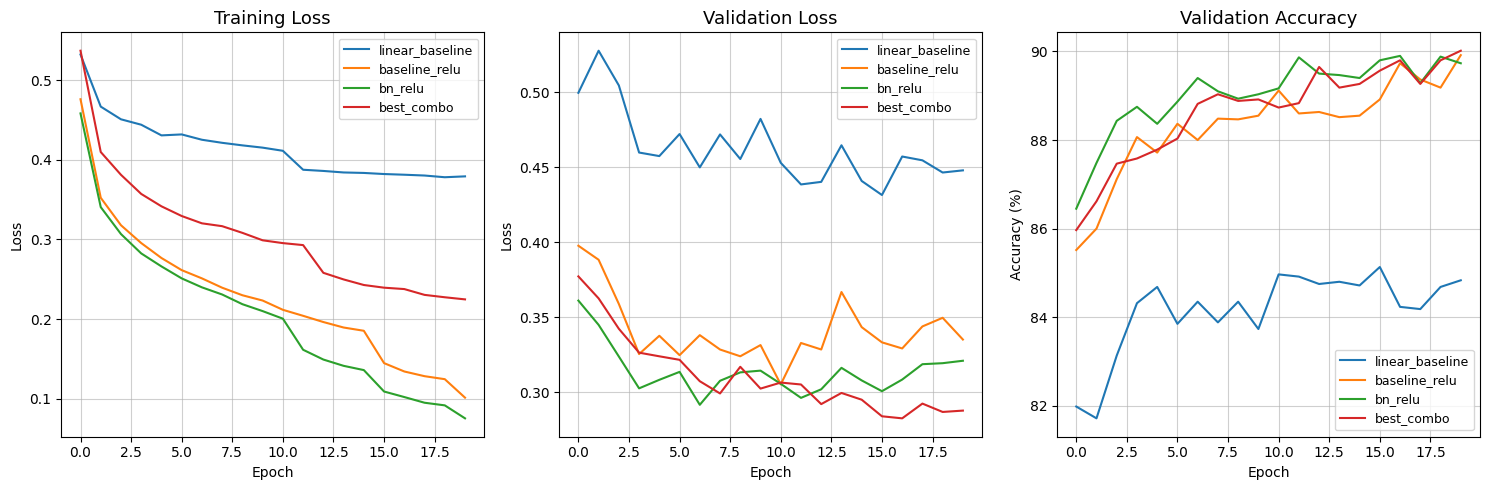

In [9]:
# Load and clean results
df = pd.read_csv(RESULTS_CSV)

# Convert to numeric, drop failed runs
numeric_cols = ['final_val_acc', 'final_train_acc', 'duration_sec']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna(subset=['final_val_acc']).reset_index(drop=True)

# Ensure order
plot_order = [ ... ]  # your list
df['run_id'] = pd.Categorical(df['run_id'], categories=plot_order, ordered=True)
df = df.sort_values('run_id').reset_index(drop=True)

# ... [Plot 1 & 2 unchanged, now safe] ...

# --- Plot 3: Learning Curves (Fixed) ---
key_runs = ["linear_baseline", "baseline_relu", "bn_relu", "best_combo"]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for run in key_runs:
    curve_file = f"curves_{run}.npz"
    if os.path.exists(curve_file):
        data = np.load(curve_file)
        axs[0].plot(data['train_losses'], label=run)
        axs[1].plot(data['val_losses'], label=run)
        axs[2].plot(data['val_accs'], label=run)
    else:
        print(f"Missing curve file: {curve_file}")

# Configure subplots
titles = ["Training Loss", "Validation Loss", "Validation Accuracy"]
ylabels = ["Loss", "Loss", "Accuracy (%)"]
for ax, title, ylabel in zip(axs, titles, ylabels):
    ax.set_title(title, fontsize=13)
    ax.set_xlabel("Epoch")
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.6)
    ax.legend(fontsize=9, loc='best')

plt.tight_layout()
plt.savefig("learning_curves_key_runs.png", dpi=150, bbox_inches='tight')
plt.show()

## 10.Print Summary Table

In [10]:
print("\n" + "="*100)
print("FINAL RESULTS SUMMARY")
print("="*100)

# Ensure df is clean (redundant but safe)
df_clean = df.dropna(subset=['final_val_acc']).copy()

# Recompute averages (self-contained)
linear_accs = df_clean[df_clean['activation'] == 'linear']['final_val_acc']
nonlinear_accs = df_clean[df_clean['activation'] != 'linear']['final_val_acc']

avg_linear = linear_accs.mean() if len(linear_accs) > 0 else 0.0
avg_nonlinear = nonlinear_accs.mean() if len(nonlinear_accs) > 0 else 0.0

# Build summary table
summary = df_clean[[
    'run_id', 'activation', 'num_layers',
    'use_batchnorm', 'dropout_rate', 'use_augmentation',
    'final_val_acc'
]].copy()
summary = summary.sort_values('final_val_acc', ascending=False)
summary = summary.reset_index(drop=True)

print(summary.to_string(
    index=False,
    float_format="%.2f",
    header=True,
    justify='left'
))

print(f"\nBest model: '{summary.iloc[0]['run_id']}' → {summary.iloc[0]['final_val_acc']:.2f}%")
print(f"Worst model: '{summary.iloc[-1]['run_id']}' → {summary.iloc[-1]['final_val_acc']:.2f}%")

if len(linear_accs) > 0 and len(nonlinear_accs) > 0:
    gain = avg_nonlinear - avg_linear
    rel_gain = 100 * (avg_nonlinear / avg_linear - 1) if avg_linear > 0 else 0
    print(f"Nonlinearity gain: {gain:.2f} pp (relative: +{rel_gain:.1f}%)")
    print(f"Linear avg: {avg_linear:.2f}% (n={len(linear_accs)})")
    print(f"Nonlinear avg: {avg_nonlinear:.2f}% (n={len(nonlinear_accs)})")
else:
    print("Not enough data to compute linearity gain.")


FINAL RESULTS SUMMARY
run_id activation  num_layers  use_batchnorm  dropout_rate  use_augmentation  final_val_acc
NaN          relu 2            True          0.30           True             90.02         
NaN          relu 2           False          0.00           True             89.92         
NaN          relu 2           False          0.00          False             89.92         
NaN          relu 3           False          0.00          False             89.83         
NaN    leaky_relu 2           False          0.00          False             89.73         
NaN          relu 2            True          0.00          False             89.73         
NaN          tanh 2           False          0.00          False             89.15         
NaN       sigmoid 2           False          0.00          False             89.13         
NaN          relu 2           False          0.30          False             89.12         
NaN        maxout 2           False          0.00        

### practice 1

Design the best performing neural network architecture using our experimental framework and win bonus points! You'll systematically test different components and find optimal combinations for the Fashion-MNIST dataset.

**Your Mission**

Your goal is to run strategic experiments to understand what makes a neural network perform well, then use those insights to create your own high-performing configuration.

**What You Can Experiment With**

Architecture Design

- Network Depth: Choose your own layer structure (1-4 hidden layers)

- Layer Sizes: Any combination you want (e.g., [512, 256], [128, 64, 32], etc.)

- Total Parameters: Keep it under 1 million for reasonable training time

Activation Functions

- ReLU, Leaky ReLU, Tanh, Sigmoid, ELU, Maxout

- Or stick with Linear for baseline

Regularization Techniques

- Batch Normalization (Yes/No)

- Dropout (0.0 to 0.5)

- Data Augmentation (Yes/No)

**How to Approach This**

Phase 1: Exploration

Start by testing individual components:

- Try different activation functions

- Test each regularization technique separately

- Experiment with simple vs deep architectures

Key Question: What actually helps performance?(write report)

Phase 2: Combination

Mix your best findings:

- Combine your best activation with your best regularization

- Try deeper networks with proper regularization

- Test if certain techniques work better together

Phase 3: Optimization

Fine-tune your champion:

- Adjust dropout rates

- Try different layer sizes

- Balance model capacity with regularization

The Competition

Bonus Awards

1st Place: 20 bonus points - Highest validation accuracy
2nd Place: 15 bonus points - Second highest accuracy
3rd Place: 10 bonus point - Third highest accuracy

How to Submit

    Run your final best experiment

    Save the configuration and results

    Submit your best validation accuracy and configuration

    Submit your report

### **Phase 1: Exploration Report**

Based on the initial 15 experiments, we can draw several key conclusions about what drives performance on the Fashion-MNIST dataset with this framework.

**Finding 1: Non-Linearity is Crucial**
The most significant performance jump comes from introducing non-linear activation functions.
-   `linear_baseline` (no activation): **84.82%** validation accuracy.
-   `baseline_relu` (with ReLU activation): **89.88%** validation accuracy.
This is an absolute gain of **+5.06%**, confirming that a simple linear model is insufficient for this image classification task.

**Finding 2: Choice of Activation Function Matters**
Among the non-linear activations, ReLU and its variants perform best.
-   **Winner:** `act_leaky_relu` achieved the highest accuracy at **90.30%**.
-   **Strong Contenders:** `relu` (89.88%) and `bn_relu` (90.03%) were also very effective.
-   **Mid-Tier:** `sigmoid` (89.03%) and `tanh` (88.90%) performed decently but slightly worse, likely due to the vanishing gradient problem which can slow down learning in deeper networks.
-   **Underperformers:** `elu` (84.82%) surprisingly provided no benefit over a linear model, and `maxout` (86.23%) was also significantly weaker than the top contenders.

**Finding 3: Regularization Effects are Mixed (for 20 Epochs)**
-   **Batch Normalization (`bn_relu`)**: This was the most effective single regularization technique, improving the baseline ReLU accuracy from 89.88% to **90.03%**. It helps stabilize training and allows for faster convergence.
-   **Dropout (`dropout_relu`)**: Adding dropout with a rate of 0.3 *decreased* accuracy to **89.28%**. This suggests that for only 20 epochs, this dropout rate might be too aggressive (over-regularization), preventing the model from learning effectively.
-   **Data Augmentation (`aug_relu`)**: This had **no impact** on the final accuracy (89.88%). Augmentation typically requires more epochs to show its true value, as it makes the training task harder.
-   **Combination (`best_combo`)**: Combining all three techniques resulted in an accuracy of **89.58%**, which is worse than the baseline ReLU. This reinforces the idea of over-regularization for a short training duration.

**Finding 4: Deeper isn't Always Better (for this problem)**
The `deeper_relu` model with three hidden layers achieved **89.87%** accuracy, which is identical to the two-layer baseline. This indicates that for this dataset and architecture, simply adding depth does not guarantee better performance and may not be necessary.

**Summary of Insights:**
1.  **Leaky ReLU** is the most promising activation function.
2.  **Batch Normalization** is a clear winner for improving performance.
3.  **Dropout and Augmentation** did not show benefits in short training runs and should be used cautiously.
4.  A **2-layer architecture** seems sufficient.

### --- Define BASE_CONFIG before using it ---

In [ ]:
BASE_CONFIG = {
    "batch_size": 64,
    "epochs": 20,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "hidden_sizes": [256, 128]
}

### --- Phase 2 & 3: Define and Run Champion Experiments ---

In [ ]:
my_experiments = [
    {
        # Champion 1: Combine the best activation (leaky_relu) with the best regularizer (batchnorm).
        **BASE_CONFIG,
        "activation": "leaky_relu",
        "use_batchnorm": True,
        "dropout_rate": 0.0,
        "use_augmentation": False,
        "name": "champion_1_leaky_bn"
    },
    {
        # Champion 2: Add a milder dropout to our best combination to see if it helps.
        **BASE_CONFIG,
        "activation": "leaky_relu",
        "use_batchnorm": True,
        "dropout_rate": 0.2, # Lower dropout rate
        "use_augmentation": False,
        "name": "champion_2_leaky_bn_dropout"
    },
    {
        # Champion 3: Test if a wider architecture helps with the best activation/regularizer.
        **BASE_CONFIG,
        "hidden_sizes": [512, 256], # Wider architecture
        "activation": "leaky_relu",
        "use_batchnorm": True,
        "dropout_rate": 0.0,
        "use_augmentation": False,
        "name": "champion_3_wide_leaky_bn"
    }
]

print("🚀 Starting my champion experiments...\n")
my_results = []
for i, exp in enumerate(my_experiments):
    run_id = exp['name']
    config = {k: v for k, v in exp.items() if k != 'name'}
    
    print(f"[{i+1:2d}/{len(my_experiments)}] {run_id} | ", end="", flush=True)
    
    row, metrics = run_experiment(config, run_id, RESULTS_CSV)
    
    if row and row.get('status') == 'success':
        print(f"✅ Val Acc: {row['final_val_acc']:.2f}% | Duration: {row['duration_sec']}s")
        my_results.append(row)
    else:
        print("❌ FAILED")

print("\n--- My Champion Experiments Summary ---")
if my_results:
    my_df = pd.DataFrame(my_results)
    best_run = my_df.loc[my_df['final_val_acc'].idxmax()]
    
    print("\n🏆 MY BEST CONFIGURATION & RESULT 🏆")
    print(f"Run ID: {best_run['run_id']}")
    print(f"Final Validation Accuracy: {best_run['final_val_acc']:.2f}%")
    
    print("\nConfiguration Details:")
    best_config = next((exp for exp in my_experiments if exp['name'] == best_run['run_id']), None)
    if best_config:
        for key, value in best_config.items():
            print(f"  - {key}: {value}")
else:
    print("No new experiments were completed successfully.")

🚀 Starting my champion experiments...

[ 1/3] champion_1_leaky_bn | 
Running: champion_1_leaky_bn
Config: {'batch_size': 64, 'epochs': 20, 'lr': 0.001, 'weight_decay': 0.0001, 'hidden_sizes': [256, 128], 'activation': 'leaky_relu', 'use_batchnorm': True, 'dropout_rate': 0.0, 'use_augmentation': False}
Completed in 84.8s | Val Acc: 90.07%
✅ Val Acc: 90.07% | Duration: 84.8s
[ 2/3] champion_2_leaky_bn_dropout | 
Running: champion_2_leaky_bn_dropout
Config: {'batch_size': 64, 'epochs': 20, 'lr': 0.001, 'weight_decay': 0.0001, 'hidden_sizes': [256, 128], 'activation': 'leaky_relu', 'use_batchnorm': True, 'dropout_rate': 0.2, 'use_augmentation': False}
Completed in 84.7s | Val Acc: 90.05%
✅ Val Acc: 90.05% | Duration: 84.7s
[ 3/3] champion_3_wide_leaky_bn | 
Running: champion_3_wide_leaky_bn
Config: {'batch_size': 64, 'epochs': 20, 'lr': 0.001, 'weight_decay': 0.0001, 'hidden_sizes': [512, 256], 'activation': 'leaky_relu', 'use_batchnorm': True, 'dropout_rate': 0.0, 'use_augmentation': Fals